In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.integrate import solve_ivp, cumtrapz
from scipy.stats import truncnorm

from models import *

%load_ext autoreload
%autoreload 2

# Experimental Data Cleaning

To apply data-driven kinetics modeling directly to experimental data, we must clean the data. Specifically, we need to:
* Eliminate errors in effluence data at the beginning and end of the experiment (e.g. from turning gas on and off)
* Correct for baseline shift in the oxygen concentration meter
* Interpolate onto common grid of time points

Below, we implement these steps and generate figures showing the process.

In [4]:
if not os.path.exists(os.path.join('results', 'data_cleaning')):
    os.mkdir(os.path.join('results', 'data_cleaning'))

oil_type, experiment = 'chichimene', '0 PSI'
hr = '2.0'
expdirname = os.path.join('datasets', oil_type, experiment)
clean_data = True

df = pd.read_excel(os.path.join(expdirname, hr+'.xls'))

INTERPNUM = 200

# Read in data
Time_in = df.Time.values/60
Time = np.copy(Time_in)
O2 = df.O2.values
CO2 = df.CO2.values
if hasattr(df, 'Temperature'):
    Temp = df.Temperature.values
elif hasattr(df, 'Temp'):
    Temp = df.Temp.values
else:
    raise Exception('Input data file {} does not contain valid field for temperature.'.format(data_path + '.xls'))

if clean_data:
    ind100C = np.amin(np.asarray(Temp > 100).nonzero())
    ind120C = np.amin(np.asarray(Temp > 120).nonzero())
    inds750 = np.asarray(Temp > 745).nonzero()[0]
    ind750C1 = inds750[np.round(0.75*inds750.shape[0]).astype(int)]
    ind750C2 = inds750[np.round(0.9*inds750.shape[0]).astype(int)]

    # Gather datapoints and perform linear regression correction
    correction_times = np.concatenate([Time[ind100C:ind120C+1], Time[ind750C1:ind750C2+1]])
    correction_O2s = np.concatenate([O2[ind100C:ind120C+1], O2[ind750C1:ind750C2+1]])
    slope, intercept, _, _, _ = linregress(correction_times, correction_O2s)
    O2_baseline = slope*Time + intercept
    O2_con_in = intercept
else:
    O2_baseline = O2[0]*np.ones_like(Time)
    O2_con_in = O2[0]

# Calculate %O2 consumption and conversion
O2_consumption = np.maximum(O2_baseline - O2, 0)

start_ind_max, end_ind_max_O2 = find_start_end(O2_consumption)
O2_consumption[:start_ind_max] = 0
O2_consumption[end_ind_max_O2:] = 0

# Finalize temperature and consumption data
Time = Time[:end_ind_max_O2]
Temp = Temp[:end_ind_max_O2]
O2_consumption = O2_consumption[:end_ind_max_O2]

# Calculate %O2 conversion
O2_conversion = cumtrapz(O2_consumption, x=Time, initial=0)
O2_conversion /= O2_conversion[-1]
dO2_conversion = np.gradient(O2_conversion, Time)


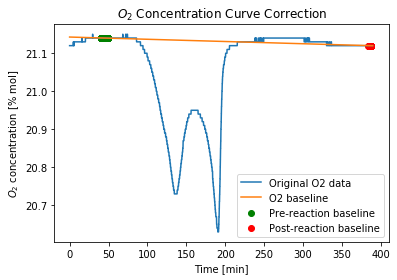

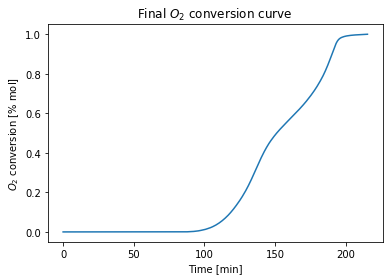

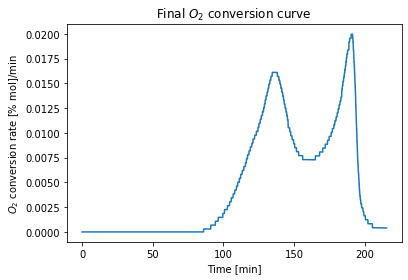

In [5]:
plt.plot(Time_in, O2)
plt.plot(Time_in, O2_baseline)
plt.scatter(Time_in[ind100C:ind120C+1], O2[ind100C:ind120C+1],color='g')
plt.scatter(Time_in[ind750C1:ind750C2+1], O2[ind750C1:ind750C2+1],color='r')
plt.xlabel('Time [min]')
plt.ylabel(r'$O_2$ concentration [% mol]')
plt.title(r'$O_2$ Concentration Curve Correction')
plt.legend(['Original O2 data', 'O2 baseline', 'Pre-reaction baseline', 'Post-reaction baseline'])
plt.savefig(os.path.join('results', 'data_cleaning','O2_concentration_original.png'))
plt.show()

# plt.plot(Time, O2_baseline[0] - O2_consumption)
# plt.xlabel('Time [min]')
# plt.ylabel(r'$O_2$ concentration [% mol]')
# plt.title(r'Cleaned $O_2$ concentration curve')
# plt.savefig(os.path.join('results', 'data_cleaning','O2_concentration_cleaned.png'))
# plt.show()

plt.plot(Time, O2_conversion)
plt.xlabel('Time [min]')
plt.ylabel(r'$O_2$ conversion [% mol]')
plt.title(r'Final $O_2$ conversion curve')
plt.savefig(os.path.join('results', 'data_cleaning','O2_conversion.png'))
plt.show()

plt.plot(Time, dO2_conversion)
plt.xlabel('Time [min]')
plt.ylabel(r'$O_2$ conversion rate [% mol]/min')
plt.title(r'Final $O_2$ conversion curve')
plt.savefig(os.path.join('results', 'data_cleaning','O2_convrate.png'))
plt.show()


# Comparison of Heavy Oil Combustion at Atmospheric Pressure

We compare Chichimene and Xinjiang heavy oil samples for RTO experiments performed at atmospheric pressure.

In [6]:
# Front matter
result_dir = os.path.join('results', 'heavy_oil_comp_0PSI') 
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

VMIN_s= 0.0
VMAX_s = 0.45

VMIN_u = -9.5
VMAX_u = -3.75

Minimum conversion rate: -2.593459757857662e-17, maximum conversion rate: 0.1200193614784798


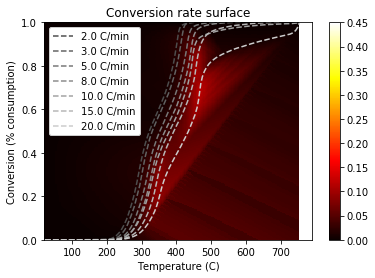

Minimum conversion rate: 0.0, maximum conversion rate: 0.4306456161569987


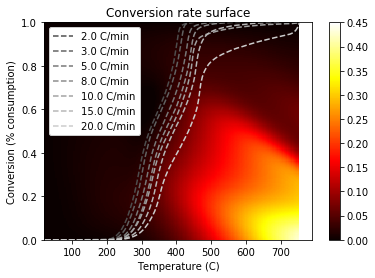

In [7]:
### CHICHIMENE DATA

# # Interpolation model
nainterp = NonArrheniusInterp(oil_type='chichimene', experiment='0 PSI', interpnum=200)
nainterp.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_interp_conrate.png'),vmin=VMIN_s,vmax=VMAX_s)

# # Unconstrained NAMLA model
# naml1 = NonArrheniusML(oil_type='chichimene',experiment='0 PSI', interpnum=200)
# naml1.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml1.print_uncertainty_surf(save_path=os.path.join(result_dir, 'chichimene_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Constrained NAMLA model
naml2 = NonArrheniusML(oil_type='chichimene',experiment='0 PSI', constrained=True, interpnum=200)
naml2.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml2.print_uncertainty_surf(save_path=os.path.join(result_dir, 'chichimene_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)



Minimum conversion rate: -2.5068306621717162e-17, maximum conversion rate: 0.07061616789222895


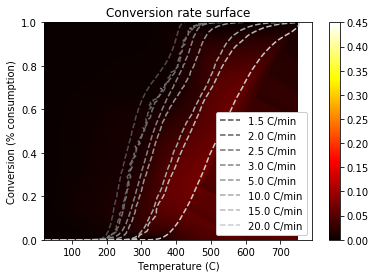

Minimum conversion rate: 0.0, maximum conversion rate: 0.14770285226039603


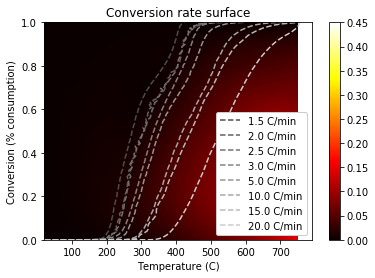

In [8]:
### XINJIANG DATA

# # Interpolation model
nainterp = NonArrheniusInterp(oil_type='xinjiang', experiment='0 PSI', interpnum=200)
nainterp.print_surf_plot(save_path = os.path.join(result_dir, 'xinjiang_interp_conrate.png'),vmin=VMIN_s,vmax=VMAX_s)

# # Unconstrained NAMLA model
# naml1 = NonArrheniusML(oil_type='xinjiang',experiment='0 PSI', interpnum=200)
# naml1.print_surf_plot(save_path = os.path.join(result_dir, 'xinjiang_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml1.print_uncertainty_surf(save_path=os.path.join(result_dir, 'xinjiang_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Constrained NAMLA model
naml2 = NonArrheniusML(oil_type='xinjiang',experiment='0 PSI', constrained=True, interpnum=200)
naml2.print_surf_plot(save_path = os.path.join(result_dir, 'xinjiang_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml2.print_uncertainty_surf(save_path=os.path.join(result_dir, 'xinjiang_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Comparison of Heavy Oil Combustion at Varying Pressure

We compare Chichimene and Tekel heavy oil samples for RTO experiments performed at 100 PSI and 200 PSI w/ 50% enriched O2 injection.

In [9]:
# Frontmatter
result_dir = os.path.join('results', 'heavy_oil_comp_pressure') 
if not os.path.exists(result_dir):
    os.mkdir(result_dir)
    
VMIN_s = 0.0
VMAX_s = 0.45

VMIN_u = -10.2
VMAX_u = -3.5

Minimum conversion rate: -2.593459757857662e-17, maximum conversion rate: 0.1200193614784798


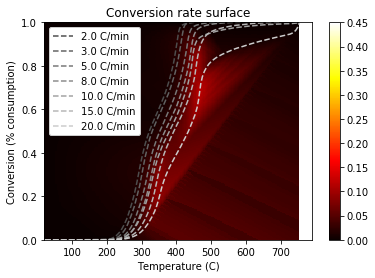

Minimum conversion rate: 0.0, maximum conversion rate: 0.4306456161569987


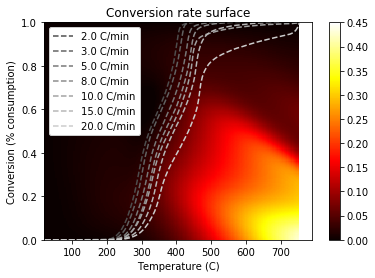

In [10]:
### CHICHIMENE DATA 0 PSI

# Interpolation model
nainterp = NonArrheniusInterp(oil_type='chichimene', experiment='0 PSI', interpnum=200)
nainterp.print_surf_plot(save_path = os.path.join(result_dir, 'interp_conrate0.png'),vmin=VMIN_s,vmax=VMAX_s)

# # Unconstrained NAMLA model
# naml1 = NonArrheniusML(oil_type='chichimene', experiment='100 PSI', interpnum=200)
# naml1.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml1.print_uncertainty_surf(save_path=os.path.join(result_dir, 'chichimene_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Constrained NAMLA model
naml2 = NonArrheniusML(oil_type='chichimene', experiment='0 PSI', constrained=True, interpnum=200)
naml2.print_surf_plot(save_path = os.path.join(result_dir, 'conrate_namla0.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml2.print_uncertainty_surf(save_path=os.path.join(result_dir, 'uncertainty_namla0.png'),vmin=VMIN_u,vmax=VMAX_u)

Minimum conversion rate: -4.1471868324408785e-17, maximum conversion rate: 0.10404907434124872


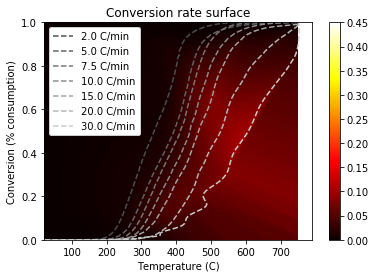

Minimum conversion rate: 0.0, maximum conversion rate: 0.14484013953256586


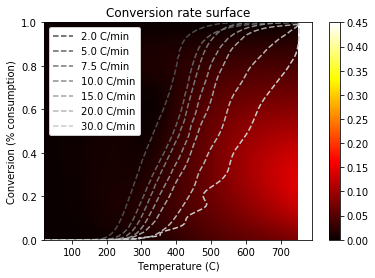

In [11]:
### CHICHIMENE DATA 100 PSI

# Interpolation model
nainterp = NonArrheniusInterp(oil_type='chichimene', experiment='100 PSI', interpnum=200)
nainterp.print_surf_plot(save_path = os.path.join(result_dir, 'interp_conrate100.png'),vmin=VMIN_s,vmax=VMAX_s)

# # Unconstrained NAMLA model
# naml1 = NonArrheniusML(oil_type='chichimene', experiment='100 PSI', interpnum=200)
# naml1.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml1.print_uncertainty_surf(save_path=os.path.join(result_dir, 'chichimene_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Constrained NAMLA model
naml2 = NonArrheniusML(oil_type='chichimene', experiment='100 PSI', constrained=True, interpnum=200)
naml2.print_surf_plot(save_path = os.path.join(result_dir, 'conrate_namla100.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml2.print_uncertainty_surf(save_path=os.path.join(result_dir, 'uncertainty_namla100.png'),vmin=VMIN_u,vmax=VMAX_u)

Minimum conversion rate: -5.384517931056914e-17, maximum conversion rate: 0.07152062498934657


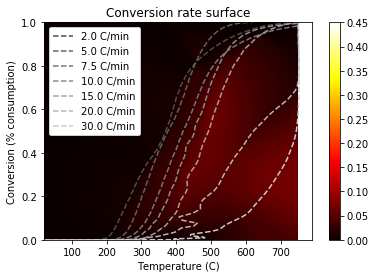

Minimum conversion rate: 0.0, maximum conversion rate: 0.07460933329532216


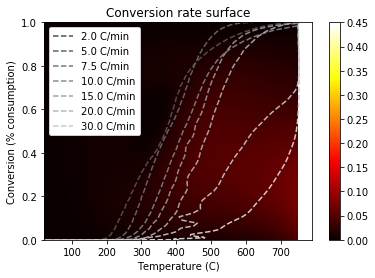

In [12]:
### CHICHIMENE DATA 200 PSI

# Interpolation model
nainterp = NonArrheniusInterp(oil_type='chichimene', experiment='200 PSI Enriched Air (50 O2)', interpnum=200)
nainterp.print_surf_plot(save_path = os.path.join(result_dir, 'interp_conrate200.png'),vmin=VMIN_s,vmax=VMAX_s)

# # Unconstrained NAMLA model
# naml1 = NonArrheniusML(oil_type='chichimene', experiment='100 PSI', interpnum=200)
# naml1.print_surf_plot(save_path = os.path.join(result_dir, 'chichimene_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml1.print_uncertainty_surf(save_path=os.path.join(result_dir, 'chichimene_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Constrained NAMLA model
naml2 = NonArrheniusML(oil_type='chichimene', experiment='200 PSI Enriched Air (50 O2)', constrained=True, interpnum=200)
naml2.print_surf_plot(save_path = os.path.join(result_dir, 'conrate_namla200.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml2.print_uncertainty_surf(save_path=os.path.join(result_dir, 'uncertainty_namla200.png'),vmin=VMIN_u,vmax=VMAX_u)

In [13]:
# ### TEKEL DATA

# # Interpolation model
# nainterp = NonArrheniusInterp(oil_type='tekel', experiment='100 PSI', interpnum=200)
# nainterp.print_surf_plot(save_path = os.path.join(result_dir, 'tekel_interp_conrate.png'),vmin=VMIN_s,vmax=VMAX_s)

# # Unconstrained NAMLA model
# naml1 = NonArrheniusML(oil_type='tekel', experiment='100 PSI', interpnum=200)
# naml1.print_surf_plot(save_path = os.path.join(result_dir, 'tekel_conrate_namla.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml1.print_uncertainty_surf(save_path=os.path.join(result_dir, 'tekel_uncertainty_namla.png'),vmin=VMIN_u,vmax=VMAX_u)

# # Constrained NAMLA model
# naml2 = NonArrheniusML(oil_type='tekel', experiment='100 PSI', constrained=True, interpnum=200)
# naml2.print_surf_plot(save_path = os.path.join(result_dir, 'tekel_conrate_cnamla.png'),vmin=VMIN_s,vmax=VMAX_s)
# naml2.print_uncertainty_surf(save_path=os.path.join(result_dir, 'tekel_uncertainty_cnamla.png'),vmin=VMIN_u,vmax=VMAX_u)

# Simulation Example - Comparison to Experimental Data (Xinjiang)
Compare data from 3 C/min and 20 C/min for Xinjiang sample. Both tested heating rates are held-out from the predictive models in both cases. 

In [14]:
# Load data
training_heating_rates = ['1.5', '2.0', '2.5', '5.0', '10.0', '15.0']
nainterp = NonArrheniusInterp(oil_type='xinjiang',experiment='0 PSI',heating_rates=training_heating_rates)
naml = NonArrheniusML(oil_type='xinjiang',experiment='0 PSI',heating_rates=training_heating_rates,constrained=True)


5.0


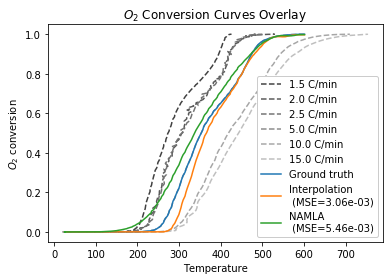

20.0


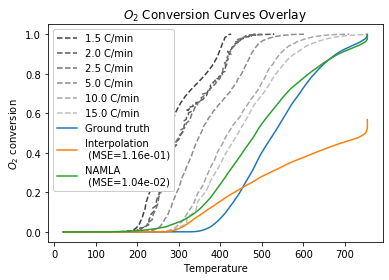

In [16]:
if not os.path.exists(os.path.join('results','data_simulation_plots')):
    os.mkdir(os.path.join('results','data_simulation_plots'))
    
# Load data
test_heating_rates = ['20.0', '5.0']
titles=['20 C/min', '5 C/min']
data_container = NonArrheniusInterp(oil_type='xinjiang', experiment='0 PSI', heating_rates = test_heating_rates)
create_simulation_overlays(nainterp,
                           naml,
                           data_container,
                           os.path.join('results','data_simulation_plots','xinjiang.png'))


# Simulation Example - Comparison to Experimental Data (Chichimene)
Compare data from 3 C/min and 20 C/min for Xinjiang sample. Both tested heating rates are held-out from the predictive models in both cases. 

In [17]:
# Load data
training_heating_rates = ['2.0', '3.0', '8.0', '10.0', '15.0']
nainterp = NonArrheniusInterp(oil_type='chichimene',experiment='0 PSI',heating_rates=training_heating_rates)
naml = NonArrheniusML(oil_type='chichimene',experiment='0 PSI',heating_rates=training_heating_rates,constrained=True)


5.0


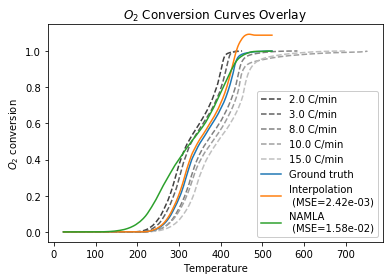

20.0


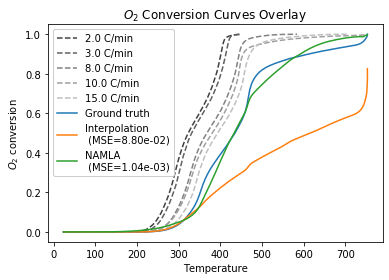

In [18]:
if not os.path.exists(os.path.join('results','data_simulation_plots')):
    os.mkdir(os.path.join('results','data_simulation_plots'))
    
# Load data
test_heating_rates = ['20.0', '5.0']
titles=['20 C/min', '5 C/min']
data_container = NonArrheniusInterp(oil_type='chichimene', experiment='0 PSI', heating_rates = test_heating_rates)

create_simulation_overlays(nainterp,
                           naml,
                           data_container,
                           os.path.join('results','data_simulation_plots','chichimene.png'))


# Simulation Example - Nonlinear Heating

Show simulation of non-linear heating rate on Xinjiang oil data and add uncertainty bounds. 

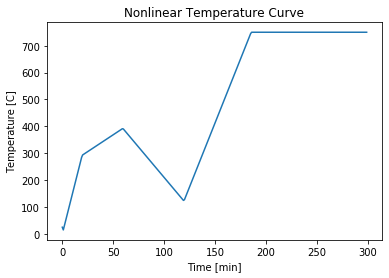

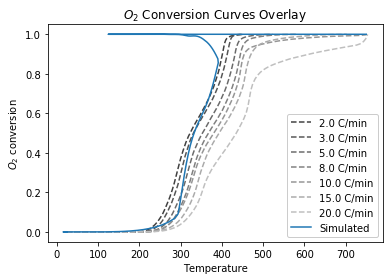

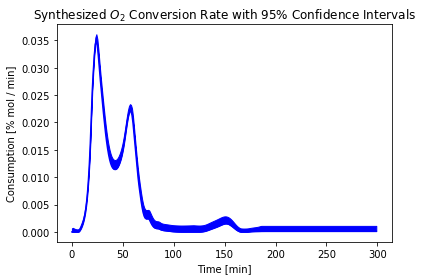

In [5]:
if not os.path.exists(os.path.join('results','data_simulation_plots')):
    os.mkdir(os.path.join('results','data_simulation_plots'))

# Create heating ramp
Time = np.arange(0,300,1)
hrs = np.asarray([15.0]*20 + [2.5]*40 + [-4.5]*60 + [9.5]*180)
Temp = np.minimum(cumtrapz(hrs, Time, initial=25.0), 750)

plt.figure()
plt.plot(Time, Temp)
plt.xlabel('Time [min]')
plt.ylabel('Temperature [C]')
plt.title('Nonlinear Temperature Curve')
plt.savefig(os.path.join('results','data_simulation_plots','nonlinear_temperature.png'))
plt.show()

# unconstrained_model = NonArrheniusML(oil_type='chichimene',experiment='0 PSI')
# t1, y1 = unconstrained_model.simulate_rto([0.0], [0.0,300.0],[Time, Temp])
# O2conv1 = np.squeeze(y1)

# dX1, sigmas1 = unconstrained_model.get_rate_and_var(Temp, O2conv1)
# lb1 = dX1 - 1.96*sigmas1
# ub1 = dX1 + 1.96*sigmas1

constrained_model = NonArrheniusML(oil_type='chichimene',experiment='0 PSI', constrained=True)
t2, y2 = constrained_model.simulate_rto([0.0], [0.0,300.0],[Time, Temp])
O2conv2 = np.squeeze(y2)

dX2, sigmas2 = constrained_model.get_rate_and_var(Temp, O2conv2)
lb2 = truncnorm.ppf(0.025, 0, np.inf, dX2, sigmas2)
ub2 = truncnorm.ppf(0.975, 0, np.inf, dX2, sigmas2)


constrained_model.overlay_curves([{'Time': Time, 'Temp': Temp, 'O2conv': O2conv2}], 
                                 legend_entries=['Simulated'], 
                                 save_path = os.path.join('results','data_simulation_plots','nonlinear_conversion.png'))


# plt.plot(t1, dX1, 'g')
plt.plot(t2, dX2, 'b')
# plt.fill_between(t1, lb1, ub1, color='g')
plt.fill_between(t2, lb2, ub2, color='b')
plt.xlabel('Time [min]')
plt.ylabel('Consumption [% mol / min]')
plt.title(r'Synthesized $O_2$ Conversion Rate with 95% Confidence Intervals')
# plt.legend(['NAMLA', 'Constrained NAMLA'])
plt.savefig(os.path.join('results','data_simulation_plots','nonlinear_consumption.png'))
plt.show()


